In [1]:
import sys
sys.path.append("../../src")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pickle
from example_pendulum import load_pendulum_data
from scipy.integrate import odeint
from autoencoder_pendulum_masked import full_network
from training_pendulum import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model0'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [3]:
training_data, validation_data = load_pendulum_data()

x,dx,ddx = validation_data['x'], validation_data['dx'], validation_data['ddx']

data_test['x'].shape (8, 648)
data_test['dx'].shape (8, 648)
data_test['ddx'].shape (8, 648)


In [4]:
training_data, validation_data = load_pendulum_data()

x,dx,ddx = training_data['x'], training_data['dx'], training_data['ddx']
x.shape

data_test['x'].shape (8, 648)
data_test['dx'].shape (8, 648)
data_test['ddx'].shape (8, 648)


(382, 648)

In [5]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    random_mask = np.random.binomial(1, 1.0, size=(382, 648))
    test_dictionary = create_feed_dictionary(test_data, params,random_mask=random_mask)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/pen_video/model0


2022-09-08 23:02:12.458240: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-09-08 23:02:12.523151: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-08 23:02:12.523253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lambda
2022-09-08 23:02:12.523275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lambda
2022-09-08 23:02:12.523479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-08 23:02:12.523537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-08 23:02:12.523553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-08 23:02:12.525185: I tensorflow/core/platform/cpu_feature_gua

NameError: name 't_train' is not defined

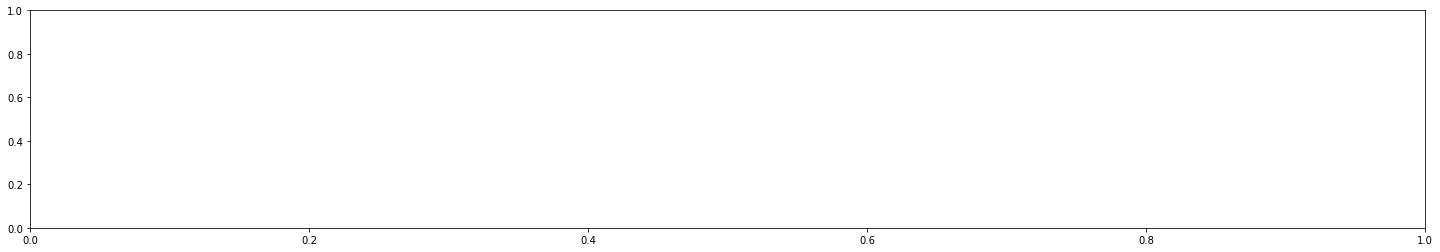

In [8]:
x = np.load("x_gaussian.npy")
dx = np.load("dx_gaussian.npy")
ddx = np.load("ddx_gaussian.npy")

x = x.reshape(790, 27, 24)
dx = dx.reshape(790, 27, 24)
ddx = ddx.reshape(790, 27, 24)

theta_list = []
center = np.array([10.5, 11.5])
for i in range(x.shape[0]):
    active_indices = x[i].T > 0.1
    coordinate_mean = np.zeros((2))
    total_active = np.sum(active_indices)
    for i1 in range(24):
        for j1 in range(27):
            if active_indices[i1,j1] == True:
                coordinate_mean[0] += i1*1.0/total_active
                coordinate_mean[1] += j1*1.0/total_active
    theta = np.arctan((coordinate_mean[0]-center[0]) / (coordinate_mean[1]-center[1]))
    theta_list.append(theta)

theta = np.array(theta_list[:390])
dtheta = np.gradient(theta, 0.034)
ddtheta = np.gradient(dtheta, 0.034)

plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(25, 4))
axs.plot(t_train, theta_list[:382], "r", label="$x_0$", marker='o', **plot_kws)
axs.legend()
axs.set(xlabel="t", ylabel="$x_k$")

fig.show()

In [ ]:
plot_kws = dict(linewidth=2)
t_train = np.arange(382)
fig, axs = plt.subplots(1, 1, figsize=(25, 4))
axs.plot(t_train, (test_set_results['z']-5)/8, "blue", label="$x_0$", **plot_kws)
axs.plot(t_train, theta_list[:382], "r", label="$x_0$", marker='o', **plot_kws)
axs.legend()
axs.set(xlabel="t", ylabel="$x_k$")

fig.show()

In [9]:
test_set_results['dz']/8

array([[-1.27761507e+00],
       [-1.14221978e+00],
       [-1.31838627e+01],
       [-2.11792737e-01],
       [-1.37445760e+00],
       [-2.36720896e+00],
       [-3.07240319e+00],
       [-4.75340271e+00],
       [-1.79470992e+00],
       [-1.90255535e+00],
       [-1.13219094e+00],
       [-1.53843355e+00],
       [-1.69780123e+00],
       [-1.44016194e+00],
       [-1.09041214e+00],
       [-1.17768455e+00],
       [-1.04188895e+00],
       [-1.13461852e+00],
       [-1.03780365e+00],
       [-1.15357590e+00],
       [-9.68938112e-01],
       [-8.73913884e-01],
       [-8.71650457e-01],
       [-9.20796394e-01],
       [-7.05320895e-01],
       [-4.15255070e-01],
       [-2.18708158e-01],
       [ 6.55891374e-02],
       [ 3.32543314e-01],
       [ 6.49759114e-01],
       [ 8.33094656e-01],
       [ 1.11265242e+00],
       [ 1.06110191e+00],
       [ 9.87653971e-01],
       [ 1.01260316e+00],
       [ 1.12002075e+00],
       [ 9.54678714e-01],
       [ 1.09589362e+00],
       [ 1.1

In [10]:
test_set_results['sindy_coefficients']

array([[-4.55479130e-05],
       [ 4.18873351e-05],
       [ 1.08898902e+00],
       [-5.92177239e-05],
       [ 4.83820986e-05],
       [-6.03254484e-05],
       [ 1.30184315e-04],
       [ 1.38123905e-05],
       [-5.36914399e-07],
       [ 4.04604292e+00],
       [ 1.18558652e-04]], dtype=float32)

In [11]:
dtheta

array([-1.28723466, -0.58651315, -0.65020009, -0.8330524 , -0.95183201,
       -2.00330845, -2.48874999, -2.48345371, -1.7099239 , -2.36778295,
       -3.21605972, -3.23223572, -2.96757408, -3.00096745, -3.31641534,
       -2.73594371, -2.54810035, -2.42088203, -2.81668144, -2.62780881,
       -1.77537925, -1.243242  , -1.20528082, -1.03127222, -0.44564075,
       -0.40139383, -0.34464695, -0.13926209,  0.24289431,  0.4614125 ,
        0.42402968,  0.89026632,  1.12179038,  1.4287782 ,  1.72818718,
        2.12504498,  2.9875779 ,  2.79031742,  2.33896609,  2.72040955,
        3.25522158,  3.1463504 ,  2.97850254,  3.04484399,  2.59887101,
        2.19517478,  2.56354736,  1.90447367,  1.48698055,  1.92155718,
        0.98042673,  0.55035302,  1.17720147,  1.02181105,  0.34956597,
        0.14922534,  0.20272195,  0.1134828 , -0.11384972, -0.20272195,
       -0.58551103, -0.22150056, -0.29378523, -0.7906763 , -0.84467236,
       -1.18086544, -1.63095306, -2.13740491, -1.62413237, -1.54

In [15]:
true_coefficients = np.zeros((12,1))
mask = np.ones(12)
true_coefficients[-2] = -4.04
t = t_train = np.arange(0, 382*0.034, 0.034)
z_sim = np.zeros((t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
z_sim = sindy_simulate_order2((test_set_results['z'][0]-5)/8, (test_set_results['dz'][0])/8, t,
                                     mask*true_coefficients,
                                     params['poly_order'], params['include_sine'])
   

In [22]:
true_coefficients[0]

0.0

In [70]:
test_set_results['z'][0]

array([12.533552], dtype=float32)

([], [])

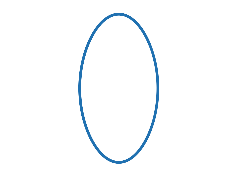

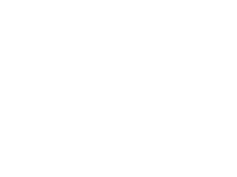

In [16]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,0].T, z_sim[:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,0].T, pendulum_sim[:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  """


(-19.05, 400.05, -1.2914498092411675, 1.2914644047972386)

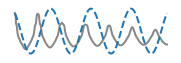

In [19]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot((test_set_results['z'][:,0]-5)/8, 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Test set analysis - in distribution

In [9]:
test_data = get_pendulum_data(10)

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/pendulum/model4


In [11]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

Decoder relative error: 0.003462
Decoder relative SINDy error: 0.003556
SINDy reltive error, z: 0.044096


In [13]:
print(test_set_results['sindy_coefficients'])

[[ 5.2228199e-08]
 [-1.6447935e-08]
 [-3.4422655e+00]
 [ 8.3557357e-09]
 [ 3.6642561e+00]
 [-1.1336120e-08]
 [-5.7204609e-08]
 [-3.4406154e+00]
 [-2.0048612e-09]
 [-7.6008892e-01]
 [ 7.7742726e-08]
 [-6.1805019e+00]]


In [14]:
print(true_coefficients)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]]


In [19]:
import numpy as np
arr = np.load("save_1.npy")
arr_truncate = arr[0:-50]
arr_mean = np.mean(arr_truncate, axis=0)
print(arr_mean)

[[ 0.        ]
 [ 0.        ]
 [-1.81524709]
 [ 0.        ]
 [ 2.07543013]
 [ 0.        ]
 [ 0.        ]
 [-1.85309271]
 [ 0.        ]
 [-0.57890595]
 [ 0.        ]
 [-4.49665182]]
